### Packages

In [3]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

### Input data

In [4]:
data_path = '../input/'
train_data = pd.read_csv(data_path + 'train_dataset.csv')
test_data = pd.read_csv(data_path + 'test_dataset.csv')
sample_sub = pd.read_csv(data_path + 'submit_example.csv')

### Pre-processing

In [5]:
train_data.head(1)

,用户编码,用户实名制是否通过核实,用户年龄,是否大学生客户,是否黑名单客户,是否4G不健康客户,用户网龄（月）,用户最近一次缴费距今时长（月）,缴费用户最近一次缴费金额（元）,用户近6个月平均消费值（元）,...,当月是否景点游览,当月是否体育场馆消费,当月网购类应用使用次数,当月物流快递类应用使用次数,当月金融理财类应用使用总次数,当月视频播放类应用使用次数,当月飞机类应用使用次数,当月火车类应用使用次数,当月旅游资讯类应用使用次数,信用分
0,a4651f98c82948b186bdcdc8108381b4,1,44,0,0,0,186,1,99.8,163.86,...,1,1,713,0,2740,7145,0,0,30,664


In [6]:
#all chinese name- -
#rename one by one
print(train_data.columns)

Index(['用户编码', '用户实名制是否通过核实', '用户年龄', '是否大学生客户', '是否黑名单客户', '是否4G不健康客户',
       '用户网龄（月）', '用户最近一次缴费距今时长（月）', '缴费用户最近一次缴费金额（元）', '用户近6个月平均消费值（元）',
       '用户账单当月总费用（元）', '用户当月账户余额（元）', '缴费用户当前是否欠费缴费', '用户话费敏感度', '当月通话交往圈人数',
       '是否经常逛商场的人', '近三个月月均商场出现次数', '当月是否逛过福州仓山万达', '当月是否到过福州山姆会员店', '当月是否看电影',
       '当月是否景点游览', '当月是否体育场馆消费', '当月网购类应用使用次数', '当月物流快递类应用使用次数',
       '当月金融理财类应用使用总次数', '当月视频播放类应用使用次数', '当月飞机类应用使用次数', '当月火车类应用使用次数',
       '当月旅游资讯类应用使用次数', '信用分'],
      dtype='object')


In [7]:
train_data.columns = ['uid','true_name_flag','age','uni_student_flag','blk_list_flag',\
                     '4g_unhealth_flag','net_age_till_now','top_up_month_diff','top_up_amount',\
                     'recent_6month_avg_use','total_account_fee','curr_month_balance',\
                     'curr_overdue_flag','cost_sensitivity','connect_num','freq_shopping_flag',\
                     'recent_3month_shopping_count','wanda_flag','sam_flag','movie_flag',\
                     'tour_flag','sport_flag','online_shopping_count','express_count',\
                     'finance_app_count','video_app_count','flight_count','train_count',\
                     'tour_app_count','score']
test_data.columns = train_data.columns[:-1]

### Feature Engineering

In [8]:
#age and net_age_in_month ---> 入网时的年龄 --- useless
#top up amount, 充值金额是整数，和小数，应该对应不同的充值途径？

def produce_offline_feat(train_data):
    train_data['top_up_amount_offline'] = 0
    train_data['top_up_amount_offline'][(train_data['top_up_amount'] % 10 == 0)&\
                               train_data['top_up_amount'] != 0] = 1
    return train_data

train_data = produce_offline_feat(train_data)
test_data = produce_offline_feat(test_data)

E:\conda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
def produce_fee_rate(train_data):
    #看importance，当月话费 和最近半年平均话费都很高，算一下当月/半年 -->稳定性
    train_data['current_fee_stability'] = \
    train_data['total_account_fee']/(train_data['recent_6month_avg_use'] + 1)
    
    #当月话费/当月账户余额
    train_data['use_left_rate'] = \
    train_data['total_account_fee']/(train_data['curr_month_balance'] + 1)
    return train_data

train_data = produce_fee_rate(train_data)
test_data = produce_fee_rate(test_data)

### Training

In [10]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

In [11]:
#para
params = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mae',
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'num_leaves': 31,
    'verbose': -1,
    'max_depth': 5,
    'lambda_l2': 5, 'lambda_l1': 0
}

In [12]:
NFOLDS = 5
train_label = train_data['score']
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=2019)
kf = kfold.split(train_data, train_label)

In [13]:
train_data.columns

Index(['uid', 'true_name_flag', 'age', 'uni_student_flag', 'blk_list_flag',
       '4g_unhealth_flag', 'net_age_till_now', 'top_up_month_diff',
       'top_up_amount', 'recent_6month_avg_use', 'total_account_fee',
       'curr_month_balance', 'curr_overdue_flag', 'cost_sensitivity',
       'connect_num', 'freq_shopping_flag', 'recent_3month_shopping_count',
       'wanda_flag', 'sam_flag', 'movie_flag', 'tour_flag', 'sport_flag',
       'online_shopping_count', 'express_count', 'finance_app_count',
       'video_app_count', 'flight_count', 'train_count', 'tour_app_count',
       'score', 'top_up_amount_offline', 'current_fee_stability',
       'use_left_rate'],
      dtype='object')

In [14]:
train_data_use = train_data.drop(['uid','score','blk_list_flag'], axis=1)
test_data_use = test_data.drop(['uid','blk_list_flag'], axis=1)

In [15]:
cv_pred = np.zeros(test_data.shape[0])
valid_best_l2_all = 0

feature_importance_df = pd.DataFrame()
count = 0
for i, (train_fold, validate) in enumerate(kf):
    print('fold: ',i, ' training')
    X_train, X_validate, label_train, label_validate = \
    train_data_use.iloc[train_fold, :], train_data_use.iloc[validate, :], \
    train_label[train_fold], train_label[validate]
    dtrain = lgb.Dataset(X_train, label_train)
    dvalid = lgb.Dataset(X_validate, label_validate, reference=dtrain)
    bst = lgb.train(params, dtrain, num_boost_round=10000, valid_sets=dvalid, verbose_eval=-1,early_stopping_rounds=50)
    cv_pred += bst.predict(test_data_use, num_iteration=bst.best_iteration)
    valid_best_l2_all += bst.best_score['valid_0']['l1']

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = list(X_train.columns)
    fold_importance_df["importance"] = bst.feature_importance(importance_type='gain', iteration=bst.best_iteration)
    fold_importance_df["fold"] = count + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    count += 1

cv_pred /= NFOLDS
valid_best_l2_all /= NFOLDS
print('cv score for valid is: ', 1/(1+valid_best_l2_all))

E:\conda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


fold:  0  training
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2953]	valid_0's l1: 14.7561
fold:  1  training
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2441]	valid_0's l1: 14.6766
fold:  2  training
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2823]	valid_0's l1: 14.7538
fold:  3  training
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2018]	valid_0's l1: 14.4784
fold:  4  training
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2265]	valid_0's l1: 14.7861
cv score for valid is:  0.06373401449598674


E:\conda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


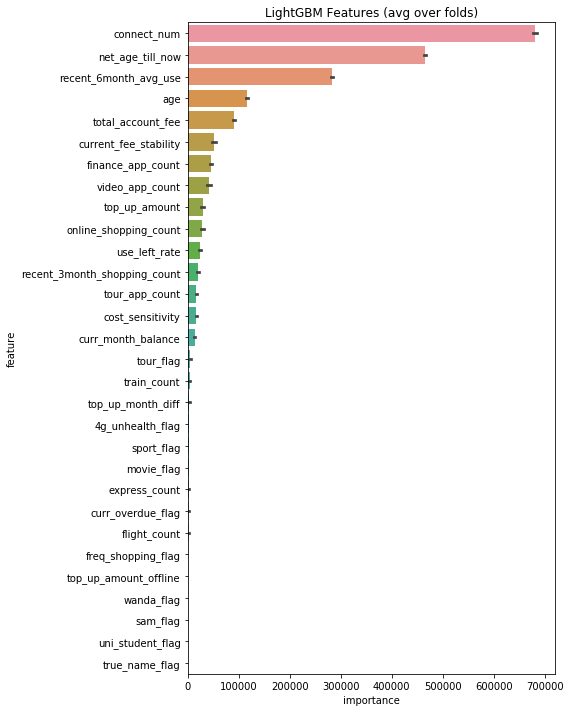

In [16]:
display_importances(feature_importance_df)

In [17]:
baseline
cv score for valid is:  0.06342856152921912 --- 0.06339265000
    
#充值金额是否为整数
cv score for valid is:  0.06343660584697094
#当月话费/半年话费
cv score for valid is:  0.06349188259250227
#当月话费/余额
cv score for valid is:  0.06350638782547711
    
#leaves 31
cv score for valid is:  0.06354362406472286
#remove l1, l2 = 5
cv score for valid is:  0.06358730556250403
#feature fraction 0.7
cv score for valid is:  0.06361478051326884 --- 0.06355141000
max_depth 5, objective l1
cv score for valid is:  0.06367445081783887
feature fraction 0.6
cv score for valid is:  0.06377264215140695 --- 0.06379867000
remove blk flag
cv score for valid is:  0.06377613710442855

SyntaxError: invalid syntax (<ipython-input-17-069aea76d45e>, line 2)

### Submit

In [18]:
test_data_sub = test_data[['uid']]
test_data_sub['score'] = cv_pred
test_data_sub.columns = ['id','score']

E:\conda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
test_data_sub['score'] = test_data_sub['score'].apply(lambda x: int(np.round(x)))

E:\conda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
test_data_sub.to_csv('../output/baseline_63776.csv', index=False)